# Import Statements

In [96]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
import dominate
from dominate.tags import *
from dominate.svg import *
import espn_api.football
from espn_api.football import League, Player
import time
import pickle
import uuid
from typing import Iterable
import math

from python import constants, functions, espn_data

# Testing and Debugging

In [104]:
from IPython.core.display import HTML


def scale_value(value, data_min, data_max, window_max):
    '''
    Scales data points to 
    '''
    return round((value - data_min) / (data_max - data_min) * window_max, 3)

In [ ]:
def df_to_svg(
        data: pd.DataFrame, 
        x_col: str, 
        y_col: str,
        chart_type: str = 'scatter',
        width: int = 500, 
        height: int = 300,
        x_tick_spacing: int = 50,
        y_tick_spacing: int = 50
):

    # margin x and y from edges of visual
    m_top, m_bottom, m_left, m_right = 10, 50, 60, 10
    # plot width and height
    P_x, P_y = width - m_left - m_right, height - m_top - m_bottom
    # tick margin (distance between axes and tick label)
    m_tick = 5

    # Bring in x and y ticks from calculate_ticks function
    include_zero = True if chart_type == 'bar' else False
    xlim, ylim = calculate_limits(data=data, x_col=x_col, y_col=y_col, x_tick_spacing=x_tick_spacing, y_tick_spacing=y_tick_spacing, include_zero=include_zero)
    # if 'ylim' in kwargs:
    #     ylim = kwargs.pop('ylim')

    x_limit_min, x_limit_max = xlim
    y_limit_min, y_limit_max = ylim

    x_ticks, y_ticks = calculate_ticks(xlim=xlim, ylim=ylim, x_tick_spacing=x_tick_spacing, y_tick_spacing=y_tick_spacing)

    d_svg = svg(
        xmlns='http://www.w3.org/2000/svg',
        width=width,
        height=height,
        viewBox=f'0 0 {width} {height}'
    )

    outer_group = g(
        font_family='Arial',
        font_size=10,
        text_anchor='middle',
        dominant_baseline='hanging'
    )
    d_svg.add(outer_group)


    

    xlabel_group = g()

    grid_path_d = []
    for i, xtick in enumerate(x_ticks):
        if i == 0 or i == (len(x_ticks) - 1):
            continue
        x = round(m_left + (xtick - x_limit_min) / (x_limit_max - x_limit_min) * P_x, 3)

        gridline = write_path([x, x], [m_top, height - m_bottom])
        grid_path_d.append(gridline)

        xtick_label = text(
            xtick,
            x=x,
            y=height - m_bottom + m_tick
        )
        xlabel_group.add(xtick_label)

    outer_group.add(xlabel_group)

    ylabel_group = g(
        text_anchor='end',
        dominant_baseline='middle'
    )
    zero_grid_path = False
    zero_ytick = False
    for ytick in y_ticks:
        y = round((height - m_bottom) - (ytick - y_limit_min) / (y_limit_max - y_limit_min) * P_y, 3)

        gridline = write_path([m_left, width - m_right], [y, y])
        grid_path_d.append(gridline)

        ytick_label = text(
            ytick,
            x=m_left - m_tick,
            y=y
        )
        ylabel_group.add(ytick_label)


        if ytick == 0:
            zero_grid_path = path(d=gridline, stroke='black')
            zero_ytick = y

    outer_group.add(ylabel_group)

    grid_path = path(
        d=' '.join(grid_path_d),
        stroke='lightgrey'
    )
    outer_group.add(grid_path)
    if zero_grid_path:
        outer_group.add(zero_grid_path)

    axis_title_group = g(font_size=16)
    outer_group.add(axis_title_group)
    xlabel = text(
        x_col,
        x=(P_x / 2 + m_left),
        y=(height - (m_bottom / 2))
    )
    ylabel = text(
        y_col,
        x=10,
        y=(P_y / 2 + m_top),
        transform=f'rotate(-90, {10}, {P_y / 2 + m_top})'
    )

    axis_title_group.add([xlabel, ylabel])
    axes = write_path([m_left, width - m_right, width - m_right, m_left], [m_top, m_top, height - m_bottom, height - m_bottom], close=True)
    axes_path = path(d=axes, fill='none', stroke='black', _id='axes')
    outer_group.add(axes_path)

    x_points = []
    y_points = []
    circles_group = g(
        stroke='black',
        stroke_width=1.5
    )
    bars_group = g(stroke='black')
    for index, row in data.iterrows():
        v_x = round(m_left + ((row[x_col] - x_limit_min) / (x_limit_max - x_limit_min) * (P_x)), 3)
        v_y = round((height - m_bottom) - ((row[y_col] - y_limit_min) / (y_limit_max - y_limit_min) * (P_y)), 3)

        bar_y = v_y if row[y_col] > 0 else zero_ytick
        bar_height = zero_ytick - v_y if row[y_col] > 0 else v_y - zero_ytick
        bar_width = 25

        bars_group.add(
            rect(
                x=v_x - bar_width / 2,
                y=bar_y,
                width=bar_width,
                height=bar_height,
                fill=constants.COLOR_DICT[row['Team'].lower()]
            )
        )
        circles_group.add(circle(cx=v_x, cy=v_y, r=4, fill=constants.COLOR_DICT[row['Team'].lower()]))
        
        x_points.append(v_x)
        y_points.append(v_y)


    if chart_type == 'line':
        line = write_path(x_points, y_points)
        line_path = path(d=line, fill='none', stroke='black')
        outer_group.add(line_path)

    if chart_type in ['scatter','line']:
        outer_group.add(circles_group)

    if chart_type == 'bar':
        outer_group.add(bars_group)

    return d_svg

In [ ]:
def calculate_limits(
        data: pd.DataFrame,
        x_col: str,
        y_col: str,
        x_tick_spacing: int,
        y_tick_spacing: int,
        include_zero: bool = False
):
    # Find the actual min and max of x and y values
    x_min, x_max = data[x_col].min(), data[x_col].max()
    y_min, y_max = data[y_col].min(), data[y_col].max()

    # Round the min/max values down/up to the nearest round number according to the tick spacing
    # If actual min/max is equal to (or within 10% of) rounded value, then will go one step further
    x_limit_min, x_limit_max = round_min(x_min, rounding=x_tick_spacing), round_max(x_max, rounding=x_tick_spacing)
    y_limit_min, y_limit_max = round_min(y_min, rounding=y_tick_spacing), round_max(y_max, rounding=y_tick_spacing)

    if include_zero:
        y_limit_min = 0 if y_limit_min >= 0 else y_limit_min
        y_limit_max = 0 if y_limit_max <= 0 else y_limit_max

    xlim = (x_limit_min, x_limit_max)
    ylim = (y_limit_min, y_limit_max)

    return xlim, ylim

In [100]:
round(np.log10(30))

S = pd.Series([1924,1693])

p = 0.10
span = max(S) - min(S)
pad = p * span

math.floor(min(S) - pad)
math.ceil(max(S) + pad)

1948

In [115]:
class SVGFigure():
    def __init__(
            self,
            Xs: Iterable,
            Ys: Iterable,
            width: int = 500,
            height: int = 300,
            xstep: int = None,
            ystep: int = None
    ):
        self.xmlns = 'http://www.w3.org/2000/svg'
        self.width = width
        self.height = height
        self.viewBox = f'0 0 {self.width} {self.height}'
        self.xcol = Xs
        self.ycol = Ys
        self.xstep = xstep
        self.ystep = ystep

        # margin x and y from edges of visual
        self.m_top, self.m_bottom, self.m_left, self.m_right = 10, 50, 60, 10
        # plot width and height
        self.P_x, self.P_y = self.width - self.m_left - self.m_right, self.height - self.m_top - self.m_bottom

        self.xlim, self.ylim = self._calculate_limits()
        self.xticks, self.yticks = self._calculate_ticks()

      

        self.tag = svg(xmlns=self.xmlns, width=self.width, height=self.height, viewBox=self.viewBox)

        border = functions.write_path([0, self.width, self.width, 0], [0, 0, self.height, self.height], close=True)
        self.tag.add(path(d=border, fill='white', _id='border'))
        axes = functions.write_path([self.m_left, self.width - self.m_right, self.width - self.m_right, self.m_left], [self.m_top, self.m_top, self.height - self.m_bottom, self.height - self.m_bottom], close=True)
        self.tag.add(path(d=axes, fill='none', stroke='black', _id='axes'))

        

    def _calculate_limits(
            self,
            include_zero: bool = False
    ):
        # Find the actual min and max of x and y values
        x_min, x_max = min(self.xcol), max(self.xcol)
        y_min, y_max = min(self.ycol), max(self.ycol)

        # Round the min/max values down/up to the nearest round number according to the tick spacing
        # If actual min/max is equal to (or within 10% of) rounded value, then will go one step further
        p = 0.10
        xspan, yspan = x_max - x_min, y_max - y_min
        xpad, ypad = p * xspan, p * yspan

        x_limit_min, x_limit_max = math.floor(x_min - xpad), math.ceil(x_max + xpad)
        y_limit_min, y_limit_max = math.floor(y_min - ypad), math.ceil(y_max + ypad)

        if include_zero:
            y_limit_min = 0 if y_limit_min >= 0 else y_limit_min
            y_limit_max = 0 if y_limit_max <= 0 else y_limit_max

        xlim = [x_limit_min, x_limit_max]
        ylim = [y_limit_min, y_limit_max]

        return xlim, ylim
    
    def _calculate_ticks(self):
        xlim_min, xlim_max = self.xlim
        ylim_min, ylim_max = self.ylim

        xstart, xend = math.ceil(xlim_min / self.xstep) * self.xstep, math.floor(xlim_max / self.xstep) * self.xstep
        ystart, yend = math.ceil(ylim_min / self.ystep) * self.ystep, math.floor(ylim_max / self.ystep) * self.ystep

        xticks = list(range(xstart, xend + self.xstep, self.xstep))
        yticks = list(range(ystart, yend + self.ystep, self.ystep))

        return xticks, yticks

    # Write svg tag to XML
    def render(self):
        return str(self.tag)
    __str__ = render


X = [2020,2021,2022,2023]
Y = [12,-3,1,8]
fig = SVGFigure(X, Y, xstep=1, ystep=2)

print(fig.ylim)
print(fig.yticks)

display(HTML(str(fig)))

[-5, 14]
[-4, -2, 0, 2, 4, 6, 8, 10, 12, 14]


In [4]:
def df_to_svg(
        data: pd.DataFrame, 
        x_col: str, 
        y_col: str,
        chart_type: str = 'scatter',
        width: int = 500, 
        height: int = 300,
        x_tick_spacing: int = 50,
        y_tick_spacing: int = 50
):

    # margin x and y from edges of visual
    m_top, m_bottom, m_left, m_right = 10, 50, 60, 10
    # plot width and height
    P_x, P_y = width - m_left - m_right, height - m_top - m_bottom
    # tick margin (distance between axes and tick label)
    m_tick = 5

    # Bring in x and y ticks from calculate_ticks function
    include_zero = True if chart_type == 'bar' else False
    xlim, ylim = functions.calculate_limits(data=data, x_col=x_col, y_col=y_col, x_tick_spacing=x_tick_spacing, y_tick_spacing=y_tick_spacing, include_zero=include_zero)
    # if 'ylim' in kwargs:
    #     ylim = kwargs.pop('ylim')

    x_limit_min, x_limit_max = xlim
    y_limit_min, y_limit_max = ylim

    x_ticks, y_ticks = functions.calculate_ticks(xlim=xlim, ylim=ylim, x_tick_spacing=x_tick_spacing, y_tick_spacing=y_tick_spacing)

    d_svg = svg(
        xmlns='http://www.w3.org/2000/svg',
        width=width,
        height=height,
        viewBox=f'0 0 {width} {height}'
    )

    outer_group = g(
        font_family='Arial',
        font_size=10,
        text_anchor='middle',
        dominant_baseline='hanging'
    )
    d_svg.add(outer_group)

    border = functions.write_path([0, width, width, 0], [0, 0, height, height], close=True)
    border_path = path(d=border, fill='white', _id='border')
    outer_group.add(border_path)

    

    xlabel_group = g()

    grid_path_d = []
    for i, xtick in enumerate(x_ticks):
        if i == 0 or i == (len(x_ticks) - 1):
            continue
        x = round(m_left + (xtick - x_limit_min) / (x_limit_max - x_limit_min) * P_x, 3)

        gridline = functions.write_path([x, x], [m_top, height - m_bottom])
        grid_path_d.append(gridline)

        xtick_label = text(
            xtick,
            x=x,
            y=height - m_bottom + m_tick
        )
        xlabel_group.add(xtick_label)

    outer_group.add(xlabel_group)

    ylabel_group = g(
        text_anchor='end',
        dominant_baseline='middle'
    )
    zero_grid_path = False
    zero_ytick = False
    for ytick in y_ticks:
        y = round((height - m_bottom) - (ytick - y_limit_min) / (y_limit_max - y_limit_min) * P_y, 3)

        gridline = functions.write_path([m_left, width - m_right], [y, y])
        grid_path_d.append(gridline)

        ytick_label = text(
            ytick,
            x=m_left - m_tick,
            y=y
        )
        ylabel_group.add(ytick_label)


        if ytick == 0:
            zero_grid_path = path(d=gridline, stroke='black')
            zero_ytick = y

    outer_group.add(ylabel_group)

    grid_path = path(
        d=' '.join(grid_path_d),
        stroke='lightgrey'
    )
    outer_group.add(grid_path)
    if zero_grid_path:
        outer_group.add(zero_grid_path)

    axis_title_group = g(font_size=16)
    outer_group.add(axis_title_group)
    xlabel = text(
        x_col,
        x=(P_x / 2 + m_left),
        y=(height - (m_bottom / 2))
    )
    ylabel = text(
        y_col,
        x=10,
        y=(P_y / 2 + m_top),
        transform=f'rotate(-90, {10}, {P_y / 2 + m_top})'
    )

    axis_title_group.add([xlabel, ylabel])
    axes = functions.write_path([m_left, width - m_right, width - m_right, m_left], [m_top, m_top, height - m_bottom, height - m_bottom], close=True)
    axes_path = path(d=axes, fill='none', stroke='black', _id='axes')
    outer_group.add(axes_path)

    x_points = []
    y_points = []
    circles_group = g(
        stroke='black',
        stroke_width=1.5
    )
    bars_group = g(stroke='black')
    for index, row in data.iterrows():
        v_x = round(m_left + ((row[x_col] - x_limit_min) / (x_limit_max - x_limit_min) * (P_x)), 3)
        v_y = round((height - m_bottom) - ((row[y_col] - y_limit_min) / (y_limit_max - y_limit_min) * (P_y)), 3)

        bar_y = v_y if row[y_col] > 0 else zero_ytick
        bar_height = zero_ytick - v_y if row[y_col] > 0 else v_y - zero_ytick
        bar_width = 25

        bars_group.add(
            rect(
                x=v_x - bar_width / 2,
                y=bar_y,
                width=bar_width,
                height=bar_height,
                fill=constants.COLOR_DICT[row['Team'].lower()]
            )
        )
        circles_group.add(circle(cx=v_x, cy=v_y, r=4, fill=constants.COLOR_DICT[row['Team'].lower()]))
        
        x_points.append(v_x)
        y_points.append(v_y)


    if chart_type == 'line':
        line = functions.write_path(x_points, y_points)
        line_path = path(d=line, fill='none', stroke='black')
        outer_group.add(line_path)

    if chart_type in ['scatter','line']:
        outer_group.add(circles_group)

    if chart_type == 'bar':
        outer_group.add(bars_group)

    return d_svg



data = pd.concat([functions.summary_table(data=constants.GAME_DATA, year=2024, week=week) for week in range(1,15)])
data = data.loc[(data['Team'] == 'Haris')]

content=df_to_svg(
        data=data,
        x_col='Week',
        y_col='Luck Score',
        chart_type='line',
        x_tick_spacing=1,
        y_tick_spacing=2
    )

# print(content)
display(HTML(str(content)))


In [6]:
seasons = [functions.summary_table(data=constants.GAME_DATA, year=year) for year in constants.YEARS]
data = pd.concat(seasons)
data = data.loc[data['Team'] == 'Andrew']

data

,Week,Year,Team,Wins,Losses,Record,Points For,Points Against,PF/G,PF/G+,PA/G,PA/G+,Avg Margin,Luck Score,Champ Flag,Ranking
7,None,2019,Andrew,6,7,6-7,1574.14,1598.96,121.09,102,123.00,104,-1.91,-7,0,8
4,None,2020,Andrew,6,7,6-7,1645.84,1545.26,126.60,104,118.87,98,7.74,-2,0,5
0,None,2021,Andrew,10,4,10-4,1901.54,1755.20,135.82,110,125.37,101,10.45,-3,1,1
3,None,2022,Andrew,8,6,8-6,1599.88,1650.06,114.28,100,117.86,104,-3.58,-4,0,4
3,None,2023,Andrew,8,6,8-6,1672.62,1532.50,119.47,102,109.46,94,10.01,2,0,4
1,None,2024,Andrew,10,4,10-4,1873.18,1681.98,133.80,113,120.14,102,13.66,-3,0,2


In [ ]:
seasons = [summary_table(data=constants.GAME_DATA, year=year) for year in constants.YEARS]
data = pd.concat(seasons)
data = data.loc[data['Team'] == 'Haris']

averages = {
    'Year':'Total',
    'Ranking':round(data['Ranking'].mean(), 2),
    'Points For':round(data['Points For'].mean(), 2),
    'Points Against':round(data['Points Against'].mean(), 2),
    'PF/G':round(data['PF/G'].mean(), 2),
    'PF/G+':round(data['PF/G+'].mean(), 2),
    'Avg Margin':round(data['Avg Margin'].mean(), 2),
    'Luck Score':round(data['Luck Score'].mean(), 2)
}

,Team,Wins,Losses,Record,Points For,Points Against,PF/G,PF/G+,PA/G,PA/G+,Avg Margin,Luck Score,Champ Flag,Ranking,Year
8,Haris,5,8,5-8,1254.30,1304.58,96.48,97,100.35,101,-3.87,-5,0,9,2018
4,Haris,7,6,7-6,1548.30,1483.26,119.10,101,114.10,96,5.00,1,0,5,2019
9,Haris,3,10,3-10,1440.82,1773.88,110.83,91,136.45,112,-25.62,-13,0,10,2020
2,Haris,8,6,8-6,1855.22,1655.12,132.52,107,118.22,96,14.29,4,0,3,2021
6,Haris,7,7,7-7,1647.48,1579.54,117.68,103,112.82,99,4.85,-3,0,7,2022
0,Haris,12,2,12-2,1801.34,1456.30,128.67,110,104.02,89,24.65,10,1,1,2023
9,Haris,3,11,3-11,1468.60,1616.88,104.90,89,115.49,98,-10.59,1,0,10,2024


In [31]:
seasons = [summary_table(data=constants.GAME_DATA, year=year) for year in constants.YEARS]
data = pd.concat(seasons)
data = data.loc[data['Team'] == 'Haris']

averages = [{
    'Year':'Total',
    'Wins':round(data['Wins'].mean(), 2),
    'Losses':round(data['Losses'].mean(), 2),
    'Ranking':round(data['Ranking'].mean(), 2),
    'Points For':round(data['Points For'].mean(), 2),
    'Points Against':round(data['Points Against'].mean(), 2),
    'PF/G':round(data['PF/G'].mean(), 2),
    'PF/G+':round(data['PF/G+'].mean(), 2),
    'Avg Margin':round(data['Avg Margin'].mean(), 2),
    'Luck Score':round(data['Luck Score'].mean(), 2)
}]

pd.DataFrame(averages)

,Year,Wins,Losses,Ranking,Points For,Points Against,PF/G,PF/G+,Avg Margin,Luck Score
0,Total,6.43,7.14,6.43,1573.72,1552.79,115.74,99.71,1.24,-0.71


In [22]:
data = constants.PLAYER_GAME_DATA.loc[constants.PLAYER_GAME_DATA['Slot Position'] != 'BE'].copy()

for position in ['QB','RB','WR','TE','RB/WR/TE','D/ST','K']:
    data_year = data.loc[data['Slot Position'] == position].copy()
    data_year['Projection Difference'] = data_year['Points'] - data_year['Projected Points']

    proj_std = data_year['Projection Difference'].std()
    proj_mean = data_year['Projection Difference'].mean()
    print(position, proj_std, proj_mean)


QB 8.161913761918564 -0.021481810115350445
RB 8.166367883015983 -0.54086743772242
WR 8.921260390231497 0.037783207463349636
TE 7.141908414082685 0.039458259325044334
RB/WR/TE 7.607146706246688 -0.49838222222222217
D/ST 6.640757041150033 1.413312555654497
K 4.615050828749014 0.12364279398762155


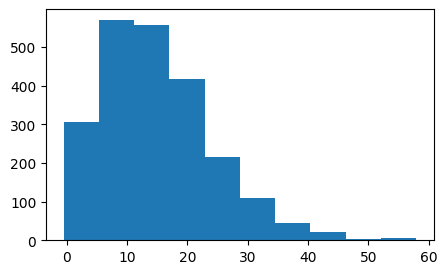

In [38]:
data_position = data.loc[data['Slot Position'] == 'WR'].copy()
data_position['Projection Difference'] = data_position['Points'] - data_position['Projected Points']

plt.figure(figsize=(5,3))
plt.hist(data_position['Points'])
plt.show()